In [2]:
li = []
li.append({'x':1})
    #load aiida environment and connect to database
from aiida import load_profile
profile = load_profile()

# load classes and functions
from aiida.orm import  *#(CifData, Code, Dict, load_node, users, load_group,
                      #Group)
from aiida.engine import submit
from aiida_kkr.tools import kkrparams, plot_kkr

from aiida.engine import workfunction
Fe_Bi2Te3_wc = load_node('efcd5b2a-b9dd-46f6-9a04-7085d0aef87c')
host_gf = Fe_Bi2Te3_wc.outputs.remote_data_gf
imp_dict = Fe_Bi2Te3_wc.inputs.impurity_info.get_dict()

imp_Z_list = [*range(21,31, 1)] + [*range(39,49, 1)]
ilayers= [3,4]
imp_dict
print(profile.database_username)
print(profile.database_name)


aiida_qs_mozumder_0077f85362e7bb995525ed5597a1b24e
default_mozumder_0077f85362e7bb995525ed5597a1b24e


In [ ]:
##### This is the edited part and my be final part

## Previous successful kkr_imp_wc process

from aiida.engine import workfunction
Fe_Bi2Te3_wc = load_node(12236)
host_gf = Fe_Bi2Te3_wc.outputs.remote_data_gf
imp_info_old = Fe_Bi2Te3_wc.inputs.impurity_info.get_dict()
# @workfunction
def submition_bunch_wc(parent_wc, builder_option, imp_num_each_step=None, imp_Z_list=None, 
                       ilayers=[],label=None,description=None, imp_setup_dict_list=None,
                       group_label= None, group_description=None,
                       ):
    import time as t
    from aiida.common.constants import elements as elmt
    from aiida.orm import (CifData, Code, Dict, load_node,load_group, StructureData,
                          Group)

    """
params:
    imp_dict(dict)

    """
    imp_dict = parent_wc.inputs.impurity_info.get_dict()
    host_gf = parent_wc.outputs.remote_data_gf
    is_imp_dict_available = False
    ## create group and store it
    try :
        existed_group= load_group(label=str(group_label))
        print('The given Group exists in DB.  So new successfull Nodes'
              + 'will be added with the group. Group pk {}'.format(existed_group.pk))
        created_group = existed_group
    except ImportError:
        if(group_label is None):
            group_label='Restarted_wc_from_uuid_{}'.format(parent_wc.uuid)
        if group_description is None:
            group_description='The parent wc impurity info {}'.format(imp_dict)
        created_group=Group(label=group_label, description=group_description)
        created_group.store()
    if imp_setup_dict_list==None:
        print("No impurity setup is provided. The impurity setup will be created as follows \n\
              Combination among all the atoms in the imp_Z_list consisting imp_num_each_step\n\
              atom in each group. Each group will be set in the ilayers position. A \n\
              combination among the ilayers element will be consider, each group will \n\
              have the same length as numbe of atoms in each atom group" )
    
        if imp_num_each_step == 1:
        ## To create all the possible imp_settings     
            all_possible_dict = {} ## All the posssible_dict combination
            all_succeful_dict = {} ## To collect all the successfull dict
            all_imp_remaider = {} ## The leftover dict without sucessfull dict

            ## order the dict
            dict_order = 0
            for Z in imp_Z_list[:] :
                    for i_layer in ilayers[:]:
                        dict_order += 1
                        imp_dict['Zimp'] = Z
#                         imp_dict['ilayer_center'] = i_layer
                        copy_imp_dict = imp_dict.copy()
                        all_possible_dict[dict_order] = copy_imp_dict


            all_imp_remaider = all_possible_dict.copy()
            is_imp_dict_available = True
            
    elif isinstance(imp_setup_dict_list, dict):
        all_possible_dict = imp_setup_dict_list ## All the posssible_dict combination
        all_succeful_dict = {} ## To collect all the successfull dict
        all_imp_remaider = {} ## The leftover dict without sucessfull dict
        all_imp_remaider = all_possible_dict.copy()
        is_imp_dict_available = True
        dict_order = len(imp_setup_dict_list)
        
    else :
        is_imp_dict_available = False
        return 'not possible to run'
    ##  some pre assumed or pre known values 
    ####-------------------------
    # Change the workflow parameter here for higher
    kkr_imp_wc_dict = parent_wc.inputs.wf_parameters.get_dict()
    kkr_imp_wc_dict['nsteps'] = 300
    kkr_imp_wc_dict['convergence_criterion'] = 1e-06
    kkr_imp_wc_dict['retrieve_kkrflex'] = False
    
    ####-------------------------
    if is_imp_dict_available :
        
        max_wc_submition = 8
        stop_here = False
        bin_success_info = {}
        bin_= {}   ## eddit it as submitted imp info
        ## wc number info
        builder_iter = 0 ## for tracking the submitted wc
        finished_iter = 0 ## tracking the finished wc
        total_wc = dict_order ## Total number of wc to be submitted

        if max_wc_submition > total_wc:
            max_wc_submition = total_wc
        ## To run all the calcualtion according to the all_possible_dict
        for order, imp_settings in all_possible_dict.items():
            ## stop_here stop all the sumbmition function if exit_status != 0
            if stop_here==True:
                break
                print('At least work chain is finished with exit_code not 0, and stop here break 000')

    ####---------------------------------------------------
            zatom = imp_settings['Zimp']
            imp_symbol = elmt[zatom]['symbol']
            label_name = imp_symbol + ':Bi2Te3'
            print(label_name)

        
            
            new_imp_dict = imp_settings.copy()
            ## step for sumitting the one job
            builder = parent_wc.get_builder_restart()
            builder.pop('remote_data_host')
            builder.remote_data_gf = host_gf
            builder.wf_parameters = Dict(dict=kkr_imp_wc_dict)
            builder.impurity_info = Dict(dict=new_imp_dict)
            builder.metadata.label = str(label_name)
            builder.options = builder_option
            builder_iter += 1
            submition = submit(builder)
            t.sleep(30)
            ## Here the bin ony takes upto eight elements of group
            bin_element = {'pk': submition.pk,
                                  'uuid': submition.uuid,
                                  'exit_status': None,
                                  'track_num': order, 'imp_info' :new_imp_dict}
            bin_[order] = bin_element
            ## The keep the activated wc equal or below the max_wc_submition
            ## that is the maximum work-chain to be in running 
            while ((builder_iter-finished_iter >= max_wc_submition) or
                (total_wc == builder_iter) or (stop_here==True) ):

    #             reduce_iter = 0
                t.sleep(120)
#                 print('sleeping for 120 second starting of the while loop')
                bin_success_wc = []
                bin_failure_wc = []
    
                if (len(bin_) == 0) :
                    ## Break the while loop here
                    break
                    
                for calc_order, sub_info in bin_.items():
                    wc_pk = bin_[calc_order]['pk']
                    calc_node = load_node(wc_pk)
                    if calc_node.is_finished == True:
                        if calc_node.exit_status == 0:
                            print('one clalc is finished')
                            bin_[calc_order]['exit_status']=0

                            ## To add the dict as a successfull dict
                            copy_to_success = all_possible_dict[calc_order].copy()
                            all_succeful_dict[calc_order] = (copy_to_success)

                            ## To delete the dict from the all_imp_remainder as it is the copy of all_possible_dict
                            all_imp_remaider.pop(calc_order)

                            ## To collect the successfull calc info such as pk, uuid
                            copy_sucess_info = bin_[calc_order].copy()
    ### change bin_successfl to sucessful_wc info
                            bin_success_info[calc_order] = copy_sucess_info
                            ## To reduce the dict from the bin_ as it is boundary that can be submit wc at one time
                            bin_success_wc.append(calc_order)
                            finished_iter += 1
                        else :
                            bin_failure_wc.append(calc_order)
                            stop_here = True
                            print('---exit_status is not 0. So, one inconistency in wc {} is found'.format(wc_pk))
#                             break ## for for loop break
#                     else:
#                         print('not even one calc in finished')

                ## To delete the element from bin_ as this wc are finished 
                ## and create the new space for others
                if (bin_success_wc != []):
                    for i in bin_success_wc[:]:
                        bin_.pop(i)
                if (bin_failure_wc != []):
                    for i in bin_failure_wc[:]:
                        bin_.pop(i)
                
                if (builder_iter-finished_iter) >= max_wc_submition or (total_wc == builder_iter) :
                    t.sleep(120)
                else : 
                    print('at least one of the group is finished')

    ####----------------------------------------------

    return all_possible_dict, all_succeful_dict, all_imp_remaider, bin_success_info
    # pk: 3264
    # builder.metadata.description = 'imp'
    # submit(builder)  # uuid: 07d65588-470a-47e0-ba19-0c1ccdb824d1
    # pk: 3264
imp_num_each_step = 1
i_layers = [4]
d_elmt_zatom = [*range(21,31, 1)] + [*range(39,49, 1)]
builder_option = Dict(dict=metadata_option_1)

imp_39 = {11:{'Rcut': 4.4, 'Zimp': 39, 'ilayer_center': 3}}

imp_setup_dict_list = {11: {'Rcut': 4.4, 'Zimp': 39, 'ilayer_center': 4},
                       12: {'Rcut': 4.4, 'Zimp': 40, 'ilayer_center': 4}}


# all_possible_dict, all_succeful_dict, all_imp_remaider, bin_success_info  = submition_bunch_wc(parent_wc= Fe_Bi2Te3_wc, builder_option= builder_option, 
#                                                                                               imp_num_each_step= 1, imp_Z_list= d_elmt_zatom,
#                                                                                               ilayers= i_layers, group_label='3d_4d_dopants_Bi2Te3_ilayer4')
# finished_bin

# all_possible_dict, all_succeful_dict, all_imp_remaider, bin_success_info  = submition_bunch_wc(Fe_Bi2Te3_wc, builder_option, imp_setup_dict_list=imp_setup_dict_list,
#                                                                                               group_label='3d_4d_dopants_Bi2Te3_ilayer4')


In [ ]:
### for finding the diference between two list of same length
def diff(list1, list2):
    derived_list = []
    for i in range(len(list1)):
        kk = list1[i] -list2[i]
        derived_list.append(kk)
    return derived_list
xx = diff(list(node_234.sites[3].position) , list(node_234.sites[4].position))


In [3]:
## building up a function to check the convergency of the kkr_imp_wc

def group_convergency_check(group, calc_class=None, processes_class=None):
    """
    Params :
    param group : pk or uuid
    
    param calc_class : Class for which convergency will be check
    """
    import matplotlib.pyplot as plt
    
    fig = plt.figure()
    axes_1 = fig.add_axes([0.1, 0.1, 0.9, 0.9])
    
#     axes_1.
    from aiida.orm import load_group, WorkChainNode
    from aiida_kkr.calculations import KkrCalculation
    group_nodes = list(load_group(group).nodes)
    for wc in group_nodes:
        if isinstance(wc, WorkChainNode):
            decendents_pk = ([i.pk for i in wc.called_descendants
                              if (isinstance(i, CalcJobNode))])
            print(decendents_pk)
        else:
            print('node class : {} and pk {}'.format(wc.class_node_type, wc.pk))
            continue
        ## Fere add the ploting function
        from aiida.orm import load_node
        %matplotlib inline
        i =decendents_pk[-1]
        loaded_node = load_node(i)
        loaded_dict = loaded_node.outputs.output_parameters.get_dict()
        plot_parameters = loaded_dict['convergence_group']['rms_all_iterations']
        axes_1.plot(plot_parameters, label='xx')

    axes_1.legend(loc=0)
    axes_1
        
# convergence_ploting([9789]) 
group_convergency_check(58)

[7688, 7755, 7784, 7843]
[7707, 7761, 7820, 7865, 7925, 7950, 7982]
[7727, 7768, 7806, 7861, 7921, 7946, 7972]
node class : process.calculation.calcjob.CalcJobNode. and pk 7790
[7891, 7898, 7916, 7941, 7966, 8010, 8105]
[8039, 8093, 8135, 8169, 8230, 8262, 8318]
[8059, 8087, 8151, 8198, 8241, 8275, 8324]
[8079, 8099, 8121, 8161, 8236, 8251]
[8194, 8206, 8224, 8257, 8305, 8348, 8432]
[9022, 9056, 9072, 9157, 9172, 9184, 9196]


pk, uuid: 9712 173285ce-a992-40c6-8e45-31dbffc12ed7
type: <class 'aiida.orm.nodes.process.workflow.workchain.WorkChainNode'>
label: Fe:Bi2Te3
description: d-block imp on the host Bi2Te3 repalceing one Bi
process type: aiida.workflows:kkr.imp
state: ProcessState.FINISHED

inputs:
[<Dict: uuid: 21108814-1f71-47f8-84c4-d27d2e01e7b7 (pk: 9709)>,
 <Code: Remote code 'voro' on claix18_init, pk: 204, uuid: 7879eb8d-2bc4-4f50-ae3c-701e92b2537b>,
 <Code: Remote code 'kkr' on claix18_init, pk: 206, uuid: 77705e42-72da-4e0a-b546-5bc7804b9a3b>,
 <Code: Remote code 'kkrflex' on claix18_init, pk: 2135, uuid: b4363ad0-9d70-43d6-bb53-c4f6e05f0b08>,
 <Dict: uuid: eb02a872-35e8-4864-bf18-cd5f7572e01c (pk: 9710)>,
 <RemoteData: uuid: 9fd31b7f-a1ab-4bfc-8dc6-af1cd7edb0d7 (pk: 3153)>,
 <Dict: uuid: 7134513a-4571-496b-a6bb-4252dc1c3370 (pk: 9711)>]

outputs:
[<WorkChainNode: uuid: 9eb7c3b9-0967-4ca7-947c-a8ac6b0a62d4 (pk: 9717) (aiida.workflows:kkr.gf_writeout)>,
 <CalcFunctionNode: uuid: f225569a-782b-4bc7

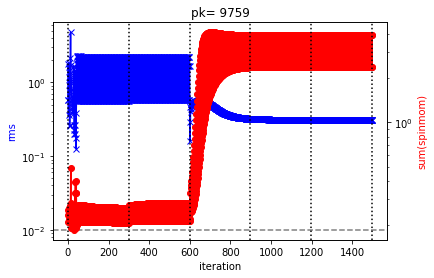

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 188.2423565917003), p…

In [4]:
from aiida_kkr.tools import plot_kkr
plot_kkr(9712)

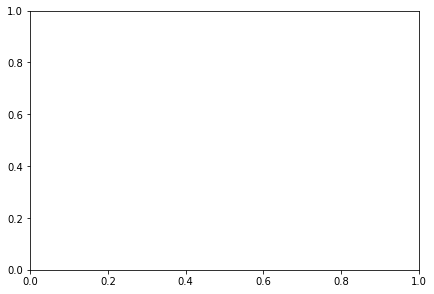

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
axes_1 = fig.add_axes([0.1, 0.1, 0.9, 0.9])

axes_1.append()

In [17]:
node_2dopants = load_node(9722)
# node_3180.inputs.impurity_info.get_dict()
node_2dopants.inputs.impurity_info.get_dict()
node_2dopants.outputs.output_parameters.get_dict()['timings_group']
# node_2dopants.inputs.wf_parameters.get_dict()

{'main0': 2.9499,
 'main2': 0.4256,
 'main1a  ': 0.4629,
 'main1b  ': 1.4926,
 'main1c  ': 6.8654,
 'main1a - tbref': 0.1103,
 'Time in Iteration': 9.2809,
 'main1b - calctref13': 0.0,
 'main1c - serial part': 0.0048}

In [443]:
node_9712 = load_node(9712)
from aiida.orm import WorkChainNode, WorkflowNode
class_9712 = node_9622.class_node_type
wc_validation = isinstance(node_9712,WorkflowNode)
wc_validation
from aiida_kkr.calculations import KkrCalculation, KkrimpCalculation

import aiida_kkr# class_9712
loaded_group = load_group(58)
node_from_group =  list(loaded_group.nodes)[0]#.class_node_type #isinstance(node_9712,WorkflowNode)
# wc_validation = isinstance(node_from_group, WorkChainNode)
# wc_validation
node_from_group.called_descendants[1].pk
decendents_pk = ([i.pk for i in node_9712.called_descendants 
                  if (isinstance(i, CalcJobNode))])
from aiida_kkr.workflows import kkr_imp_wc
# node_9712.proc
load_node(decendents_pk[0]).outputs.output_parameters.get_dict()
node_9722 = load_node(9742)
xx=node_9722.process_class
# isinstance(node_9722.process_class, KkrCalculation)
# node_9722.outputs.output_parameters.get_dict()['convergence_group']

In [444]:
xx

aiida_kkr.calculations.voro.VoronoiCalculation

In [64]:
all_possible_dict = {}
# for Z in range(len(imp_Z_list)):
#     for i_layer in range(len(ilayers)):

dict_order = 0
for Z in imp_Z_list[:2] :
        for i_layer in ilayers[:]:
            dict_order += 1
            imp_dict['Zimp'] = Z
            imp_dict['ilayer_center'] = i_layer
            copy_imp_dict = imp_dict.copy()
            all_possible_dict[dict_order] = copy_imp_dict


In [302]:
Structre_Bi2Te3 = load_node(234)
print(Structre_Bi2Te3.uuid)
Structre_Bi2Te3.get_pymatgen()

c1626804-5b71-450c-91c4-aa7197d85279


Structure Summary
Lattice
    abc : 10.472657559692419 10.472657559692419 10.472657559692438
 angles : 24.157680577616187 24.157680577616187 24.157680577615878
 volume : 169.06740315520517
      A : 2.1914815820078 1.2652524812963 10.162337378619
      B : -2.1914815820078 1.2652524812963 10.162337378619
      C : -8.1101110346236e-17 -2.5305049625927 10.162337378619
PeriodicSite: Te (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Te (-0.0000, 2.5305, 26.7879) [1.2120, 1.2120, 0.2120]
PeriodicSite: Te (-0.0000, 0.0000, 24.0238) [0.7880, 0.7880, 0.7880]
PeriodicSite: Bi (2.1915, 1.2653, 22.3571) [1.4000, 0.4000, 0.4000]
PeriodicSite: Bi (2.1915, 1.2653, 28.4545) [1.6000, 0.6000, 0.6000]
PeriodicSite:  (-0.0000, 2.5305, 23.3734) [1.1000, 1.1000, 0.1000]
PeriodicSite:  (-0.0000, 0.0000, 27.4383) [0.9000, 0.9000, 0.9000]
PeriodicSite:  (-0.0000, 2.5305, 29.4708) [1.3000, 1.3000, 0.3000]
PeriodicSite:  (-0.0000, 0.0000, 21.3409) [0.7000, 0.7000, 0.7000]
PeriodicSite:  (2.191

300

In [18]:
node_9712 = load_node(9712)
node_9712.called_descendants#[-4].pk#process_label#class_node_typUntitled.ipynbe
#.get_outgoing().all()
# node_9712.
node_9789 = load_node(9789)
retrieved_list = node_9789.outputs.output_parameters.get_dict()#get_dict() #get_retrieve_list()
# out_kkrimp = retrieved_list[0]
# retrieved_list
# node_9712.get_outgoing().all()

In [28]:
from aiida.orm import load_group, Group, User, load_node
new_group = Group(label='3d_4d_dopants_Bi2Te3_ilayer3', description='Relacing the Bi at i-layer 3 by 3d elements' )
new_group.store()

# Group.uuid
# group_58 = Group(63)
# group_nodes = list(group_58.nodes)
# group_nodes

IntegrityError: duplicate key value violates unique constraint "db_dbgroup_name_type_12656f33_uniq"
DETAIL:  Key (label, type_string)=(3d_4d_dopants_Bi2Te3_ilayer3, core) already exists.


In [337]:
## Loading the node 371
node_371 = load_node(371)

node_371.get_outgoing().all_nodes()

[<SinglefileData: uuid: 2e6916bf-6c94-47c0-a080-f90f65e811e7 (pk: 388)>,
 <Dict: uuid: d21ec624-7f53-4ef0-b6b2-f43d26c287cf (pk: 391)>,
 <CalcFunctionNode: uuid: bb994a0c-1c96-4090-8365-862c7a870b4b (pk: 380) (aiida_kkr.workflows.kkr_imp_sub.extract_imp_pot_sfd)>,
 <CalcFunctionNode: uuid: 0bbbd991-7753-488d-8aaa-280e2aa334c5 (pk: 374) (aiida_kkr.tools.common_workfunctions.kick_out_corestates_wf)>,
 <CalcFunctionNode: uuid: 06922361-adf5-4c88-8aaf-075e5a74f3ae (pk: 387) (aiida_kkr.workflows.kkr_imp_sub.extract_imp_pot_sfd)>,
 <CalcFunctionNode: uuid: 080601ce-3dcf-43e1-8bb4-8983010c2d6b (pk: 390) (aiida_kkr.tools.save_output_nodes.create_out_dict_node)>,
 <CalcJobNode: uuid: 367e7915-b16a-4424-8fb0-c6599730e66c (pk: 383) (aiida.calculations:kkr.kkrimp)>,
 <CalcJobNode: uuid: 16ab4679-37df-4ef0-b3e7-4f2775eb6b0c (pk: 376) (aiida.calculations:kkr.kkrimp)>]

In [206]:
##### This is the edited part and my be final part

## Prevget_outgoingful kkr_imp_wc process
from aiida.engine import workfunction
Fe_Bi2Te3_wc = load_node('efcd5b2a-b9dd-46f6-9a04-7085d0aef87c')
host_gf = Fe_Bi2Te3_wc.outputs.remote_data_gf
imp_info_old = Fe_Bi2Te3_wc.inputs.impurity_info.get_dict()
# @workfunction
def submition_bunch_wc(parent_wc, builder_option, imp_num_each_step=None, imp_Z_list=None, 
                       ilayers=[],label=None,description=None, imp_setup_dict_list=None,
                       ):
    import time as t
    from aiida.common.constants import elements as elmt
    from aiida.orm import CifData, Code, Dict, load_node, StructureData
    

    """
params:
    imp_dict(dict)

    """
    imp_dict = parent_wc.inputs.impurity_info.get_dict()
    host_gf = parent_wc.outputs.remote_data_gf
    is_imp_dict_available = False
                
    if imp_setup_dict_list==None:
        print("No impurity setup is provided. The impurity setup will be created as follows \n\
              Combination among all the atoms in the imp_Z_list consisting imp_num_each_step\n\
              atom in each group. Each group will be set in the ilayers position. A \n\
              combination among the ilayers element will be consider, each group will \n\
              have the same length as numbe of atoms in each atom group" )
    
        if imp_num_each_step == 1:
        ## To create all the possible imp_settings     
            all_possible_dict = {} ## All the posssible_dict combination
            all_succeful_dict = {} ## To collect all the successfull dict
            all_imp_remaider = {} ## The leftover dict without sucessfull dict
            ## order the dict
            dict_order = 0
            for Z in imp_Z_list[:] :
#                     for i_layer in ilayers[:]:
                        dict_order += 1
                        imp_dict['Zimp'] = [Z]*imp_num_each_step                        
                        copy_imp_dict = imp_dict.copy()
                        all_possible_dict[dict_order] = copy_imp_dict

            all_imp_remaider = all_possible_dict.copy()
            is_imp_dict_available = True
            
    elif isinstance(imp_setup_dict_list, dict):
        all_possible_dict = imp_setup_dict_list ## All the posssible_dict combination
        all_succeful_dict = {} ## To collect all the successfull dict
        all_imp_remaider = {} ## The leftover dict without sucessfull dict
        all_imp_remaider = all_possible_dict.copy()
        is_imp_dict_available = True
        dict_order = len(imp_setup_dict_list)
        
    else :
        is_imp_dict_available = False
        return 'not possible to run'
    ##  some pre assumed or pre known values 
    ####-------------------------
    # Change the workflow parameter here for higher
    kkr_imp_wc_dict = parent_wc.inputs.wf_parameters.get_dict()
    kkr_imp_wc_dict['nsteps'] = 300
    kkr_imp_wc_dict['convergence_criterion'] = 1e-06
    
    ####-------------------------
    if is_imp_dict_available :
        
        max_wc_submition = 2
        stop_here = False
        bin_success_info = {}
        bin_= {}   ## eddit it as submitted imp info
        ## wc number info
        builder_iter = 0 ## for tracking the submitted wc
        finished_iter = 0 ## tracking the finished wc
        total_wc = dict_order ## Total number of wc to be submitted


        ## To run all the calcualtion according to the all_possible_dict
        for order, imp_settings in all_possible_dict.items():
            ## stop_here stop all the sumbmition function if exit_status != 0
            if stop_here==True:
                break
                print('At least work chain is finished with exit_code not 0, and stop here break 000')

    ####---------------------------------------------------
            zatom = imp_settings['Zimp']
            imp_symbol = elmt[zatom]['symbol']
            label_name = imp_symbol + ':Bi2Te3'
            print(label_name)

        
            
            new_imp_dict = imp_settings.copy()
            ## step for sumitting the one job
            builder = parent_wc.get_builder_restart()
            builder.pop('remote_data_host')
            builder.remote_data_gf = host_gf
            builder.wf_parameters = Dict(dict=kkr_imp_wc_dict)
            builder.impurity_info = Dict(dict=new_imp_dict)
            builder.metadata.label = label_name
            builder.options = builder_option
            builder_iter += 1
#             submition = submit(builder)
            t.sleep(30)
            ## Here the bin ony takes upto eight elements of group
            bin_element = {'pk': submition.pk,
                                  'uuid': submition.uuid,
                                  'exit_status': None,
                                  'track_num': order, 'imp_info' :new_imp_dict}
            bin_[order] = bin_element
            ## The keep the activated wc equal or below the max_wc_submition
            ## that is the maximum work-chain to be in running 
            while ((builder_iter-finished_iter >= max_wc_submition) or
                (total_wc == builder_iter) ):

    #             reduce_iter = 0
                t.sleep(120)
                print('sleeping for 120 second starting of the while loop')
                bin_pop_num = []
                for calc_order, sub_info in bin_.items():

                    calc_node = load_node(bin_[calc_order]['pk'])
                    if calc_node.is_finished == True:
                        if calc_node.exit_status == 0:
                            print('one clalc is finished')
                            bin_[calc_order]['exit_status']=0

                            ## To add the dict as a successfull dict
                            copy_to_success = all_possible_dict[calc_order].copy()
                            all_succeful_dict[calc_order] = (copy_to_success)

                            ## To delete the dict from the all_imp_remainder as it is the copy of all_possible_dict
                            all_imp_remaider.pop(calc_order)

                            ## To collect the successfull calc info such as pk, uuid
                            copy_sucess_info = bin_[calc_order].copy()
    ### change bin_successfl to sucessful_wc info
                            bin_success_info[calc_order] = copy_sucess_info
                            ## To reduce the dict from the bin_ as it is boundary that can be submit wc at one time
                            bin_pop_num.append(calc_order)
                            finished_iter += 1
                        else :
                            stop_here = True
                            print('---exit_status is not 0 So, chain is brocken. break 111 ')
                            break ## for for loop break
                    else:
                        print('not even one calc in finished')

                ## To delete the element from bin_ as this wc are finished 
                ## and create the new space for others
                if bin_pop_num != []:
                    for i in bin_pop_num[:]:
                        bin_.pop(i)
                if stop_here == True or (finished_iter == total_wc):
                    print('breaking the while loop. 222')
                    break ## for while loop break
                if (builder_iter-finished_iter) >= max_wc_submition or (total_wc == builder_iter) :
                    t.sleep(120)
                    print('sleeping for 120 second')
                else : 
                    print('at least one of the group is finished')

    ####----------------------------------------------

        return all_possible_dict, all_succeful_dict, all_imp_remaider, bin_success_info
    # pk: 3264
    # builder.metadata.description = 'imp'
    # submit(builder)  # uuid: 07d65588-470a-47e0-ba19-0c1ccdb824d1
    # pk: 3264
imp_num_each_step = 1
i_layers = [4]
d_elmt_zatom = [*range(21,31, 1)] + [*range(39,49, 1)]
builder_option = Dict(dict=metadata_option_1)

imp_39 = {11:{'Rcut': 4.4, 'Zimp': 39, 'ilayer_center': 3}}

imp_setup_dict_list = {10: {'Rcut': 4.4, 'Zimp': 30, 'ilayer_center': 3}, 
12: {'Rcut': 4.4, 'Zimp': 40, 'ilayer_center': 3}, 13: {'Rcut': 4.4, 'Zimp': 41, 'ilayer_center': 3},
14: {'Rcut': 4.4, 'Zimp': 42, 'ilayer_center': 3}, 15: {'Rcut': 4.4, 'Zimp': 43, 'ilayer_center': 3},
16: {'Rcut': 4.4, 'Zimp': 44, 'ilayer_center': 3}, 17: {'Rcut': 4.4, 'Zimp': 45, 'ilayer_center': 3},
18: {'Rcut': 4.4, 'Zimp': 46, 'ilayer_center': 3}, 19: {'Rcut': 4.4, 'Zimp': 47, 'ilayer_center': 3},
20: {'Rcut': 4.4, 'Zimp': 48, 'ilayer_center': 3}}

all_possible_dict, all_succeful_dict, all_imp_remaider, bin_success_info  = submition_bunch_wc(parent_wc= Fe_Bi2Te3_wc, builder_option= builder_option, imp_num_each_step=1
                                                                                                  imp_Z_list=d_elmt_zatom,ilayers= i_layers, )
# finished_bin

# all_possible_dict, all_succeful_dict, all_imp_remaider, bin_success_info  = submition_bunch_wc(Fe_Bi2Te3_wc, builder_option, imp_setup_dict_list=imp_39)


SyntaxError: invalid syntax (<ipython-input-206-7360921497ab>, line 188)

In [161]:
imp_num = 3
i_layer_list = 10
dict_order = 0
dict_imp_ilayer = {}

while imp_num<i_layer:
    for i in range(imp_num,i_layer_list+1,1):
        dict_imp_ilayer[dict_order] = list(*range(i-imp_num, i-1))
        dict_order += 1
    imp_num += 1
    

TypeError: '<' not supported between instances of 'int' and 'list'

In [205]:
# node_9025 = load_node(9025)
node_ = load_node('efcd5b2a-b9dd-46f6-9a04-7085d0aef87c')
# node_9025.inputs.impurity_infoimpu.get_dict
nodes = node_.inputs.remote_data_host.get_incoming().
nodes

[<CalcJobNode: uuid: f6b0a1a3-9a88-464d-8129-0668f39366d2 (pk: 3152) (aiida.calculations:kkr.kkr)>,
 <WorkFunctionNode: uuid: 0faa44ba-5839-4a59-b7b2-31fee44a9e62 (pk: 3159) (aiida_kkr.workflows.kkr_scf.create_scf_result_node)>,
 <WorkChainNode: uuid: 13a08a52-44ec-4916-8d68-9579bcde4810 (pk: 3105) (aiida.workflows:kkr.scf)>]

In [52]:
all_possible_dict
ll = [{'Rcut': 4.4, 'Zimp': 21, 'ilayer_center': 4},{'Rcut': 4.4, 'Zimp': 22, 'ilayer_center': 4},
         {'Rcut': 4.4, 'Zimp': 23, 'ilayer_center': 4}, {'Rcut': 4.4, 'Zimp': 23, 'ilayer_center': 4}]